In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from scipy.stats import randint, uniform

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [5]:
def create_model(num_neurons=32, dropout_rate=0.0, optimizer='adam'):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [6]:
model = KerasClassifier(build_fn=create_model, verbose=1)

In [9]:
param_dist = {
    'model__num_neurons': [16, 32, 64, 128],  # Add 'model__' prefix
    'model__dropout_rate': [0.0, 0.2, 0.5],    # Add 'model__' prefix
    'model__optimizer': ['adam', 'rmsprop'],   # Add 'model__' prefix
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 50]
}

In [10]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scoring,
    refit='f1_macro',
    n_jobs=-1,
    return_train_score=True,
    cv=skf,
    random_state=42,
)
random_search_result = random_search.fit(X_train, y_train)

Epoch 1/20


c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8284 - loss: 0.4239
Epoch 2/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8507 - loss: 0.3445
Epoch 3/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8606 - loss: 0.3282
Epoch 4/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8584 - loss: 0.3214
Epoch 5/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8616 - loss: 0.3250
Epoch 6/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8695 - loss: 0.3015
Epoch 7/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8620 - loss: 0.3120
Epoch 8/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8714 - loss: 0.3023
Epoch 9/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8611 - loss: 0.3158
Epoch 10/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8658 - loss: 0.3170
Epoch 11/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8618 - loss: 0.3143
Epoch 12/20
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

In [13]:
best_params = random_search_result.best_params_

committee_estimators = []
for i in range(5):
    model_i = KerasClassifier(build_fn=create_model,
                              num_neurons=best_params['model__num_neurons'],
                              dropout_rate=best_params['model__dropout_rate'],
                              optimizer=best_params['model__optimizer'],
                              batch_size=best_params['batch_size'],
                              epochs=best_params['epochs'],
                              verbose=0,
                              random_state=i)
    committee_estimators.append((f"nn_{i}", model_i))

# Combine them using a VotingClassifier (for classification)
committee = VotingClassifier(estimators=committee_estimators, voting='soft')
committee.fit(X_train, y_train)

c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\T-Gamer\miniconda3\envs\data-mining\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass a

VotingClassifier(estimators=[('nn_0',
                              KerasClassifier(batch_size=16, build_fn=<function create_model at 0x0000026F8F2607C0>, dropout_rate=0.0, epochs=20, num_neurons=128, optimizer='adam', random_state=0, verbose=0)),
                             ('nn_1',
                              KerasClassifier(batch_size=16, build_fn=<function create_model at 0x0000026F8F2607C0>, dropout_rate=0.0, epochs=20, num_neurons=128, optimizer='...
                              KerasClassifier(batch_size=16, build_fn=<function create_model at 0x0000026F8F2607C0>, dropout_rate=0.0, epochs=20, num_neurons=128, optimizer='adam', random_state=3, verbose=0)),
                             ('nn_4',
                              KerasClassifier(batch_size=16, build_fn=<function create_model at 0x0000026F8F2607C0>, dropout_rate=0.0, epochs=20, num_neurons=128, optimizer='adam', random_state=4, verbose=0))],
                 voting='soft')

In [26]:
pd.set_option('display.max_columns', None)

In [14]:
preds = cross_val_predict(committee, X_train, y_train, cv=skf, n_jobs=-1)

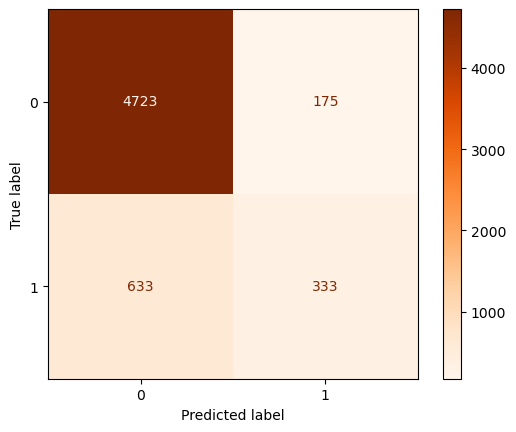

In [15]:
cm = confusion_matrix(y_train, preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=random_search_result.best_estimator_.classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [16]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8818    0.9643    0.9212      4898
           1     0.6555    0.3447    0.4518       966

    accuracy                         0.8622      5864
   macro avg     0.7687    0.6545    0.6865      5864
weighted avg     0.8445    0.8622    0.8439      5864



In [17]:
joblib.dump(committee, 'models/committee_mlp.pkl')

['models/committee_mlp.pkl']